## Predictor Corrector Method

In [1]:
import numpy as np
from numpy import linalg
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from scipy.linalg import ldl
import scipy.linalg

In [2]:
def _cvxopt(x, z, s, G, g, A, b, eta, maxk):
    
    # Input to the solver:
    # x : Primary variables of which we have to find the optimal value size: 
    # z : Lagrangian variables
    # s : Slack variables
    # G : Hessian
    
    path = []
    path.append(x)
    eta = eta
    
    #compute the residuals
    
    mA, nA = A.shape[0], A.shape[1]
    
    e = np.matrix(np.ones((nA,1)))
    
    rL = G*x + g - A*z
    rs = s - A.T*x + b
    rsz = np.multiply(s,z)
    mu = np.sum(np.multiply(z,s))/nA
    
    # number of iteration, epsilon, tolerance
    
    k = 0
    #maxk = 1000
    eps_L = 1e-16
    eps_s = 1e-16
    eps_mu = 1e-16
    
    while (k <= maxk and np.linalg.norm(rL)>=eps_L and np.linalg.norm(rs)>=eps_s and abs(rsz).all()>=eps_mu):
        
        # solve the sytem of equation : predictor step
        
        G_bar = G + A*(np.diag((z/s).A1))*A.T
        r_bar = A*((rsz - np.multiply(z,rs))/s)
        g_bar = -1*(rL + r_bar)
        L = np.linalg.cholesky(G_bar)
        
        dx_a = np.linalg.inv(L.T)*(np.linalg.inv(L)*g_bar)
        ds_a = -1*rs + A.T*dx_a
        dz_a = -1*(rsz + np.multiply(z,ds_a))/s
        
        # compute alpha_aff
        
        alpha_a = 1
        
        idx_z = np.where(dz_a < 0)
        
        if (len(idx_z[0])!=0):
            alpha_a =  min(alpha_a, np.min(-z[idx_z]/dz_a[idx_z]))
            
        idx_s = np.where(ds_a < 0)
        
        if (len(idx_s[0])!=0):
            alpha_a =  min(alpha_a, np.min(-s[idx_s]/ds_a[idx_s]))
        
        mu_a = (s + alpha_a*ds_a).T*((z + alpha_a*dz_a))/nA
        
        sigma = np.linalg.matrix_power(mu_a/mu,3)
        
        
        # solve the sytem of equation : corrector step
        
        rsz = rsz + np.multiply(ds_a,dz_a) - sigma[0,0]*mu*e
        r_bar = A*((rsz - np.multiply(z,rs))/s)
        g_bar = -(rL + r_bar)
        dx = np.linalg.inv(L.T)*(np.linalg.inv(L)*g_bar)
        ds = -rs + A.T*dx_a
        dz = -(rsz + np.multiply(z,ds_a))/s 
        
        # compute alpha
        
        alpha = 1
        
        idx_z = np.where(dz < 0)
        
        if (len(idx_z[0])!=0):
            alpha =  min(alpha, np.min(-z[idx_z]/dz[idx_z]))
            
        idx_s = np.where(ds < 0)
        
        if (len(idx_s[0])!=0):
            alpha =  min(alpha, np.min(-s[idx_s]/ds[idx_s]))
            
        # Update x, z, s
  
        x = x + eta*np.multiply(alpha,dx)
        z = z + eta*np.multiply(alpha,dz)
        s = z + eta*np.multiply(alpha,ds)
        
        k = k+1
        
        # Update rhs and mu
        
        rL = G*x + g - A*z
        rs = s - A.T*x + b
        rsz = np.multiply(s,z)
        mu = np.sum(np.multiply(z,s))/nA
        
        path.append(x)
        
    return x, path, k



def plot(x, y, w, b):
    xx = np.linspace(min(x[:,0])-0.1, max(x[:,0])+0.1, 100)
    yy = np.linspace(min(x[:,1])-0.3, max(x[:,1])+0.3, 100)
    YY, XX = np.meshgrid(yy, xx)
    xy = np.array(np.vstack([XX.ravel(), YY.ravel()]).T)
    pred=[0]*len(xy)
    pred=np.array(pred)
    
    Threshold=[0]*len(xy)
        
    for i in range(0,len(xy)):
        
        Threshold[i] = classify(xy[i,:].reshape(1,-1)[0],w,b)

        if Threshold[i]>=0:
            pred[i]=1
        else:
            pred[i]=0
    
    Z=pred.reshape(XX.shape)
    f = plt.figure(figsize=(14,5))
    ax = f.add_subplot(121)
    ax2 = f.add_subplot(122)
    ax.scatter(X[:, 0], X[:, 1], s=50,c=y)
    plt.subplot(122)
    ax2.contourf(XX, YY, Z,cmap=plt.cm.coolwarm,alpha=0.9)
    ax2.scatter(X[:, 0], X[:, 1], s=50,c=y)
    plt.show()

    
def classify(x, w, b):

    return np.dot(w.T,x) + b

### Test problem 1: Linear SVM optimization

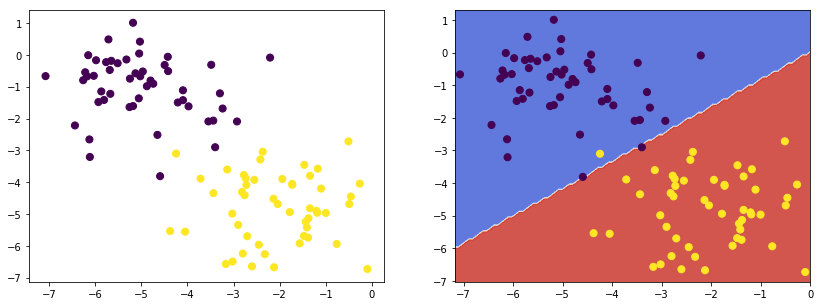

In [57]:
X, y = make_blobs(n_samples=100, centers=2, random_state = 33)
y[np.where(y==0.0)]=-1

# We'll solve primal SVM optimization problem for linear case
# Refer to CS229 Andrew Ng course for SVM formulation

# min (1/2)W.T*W
# s.t. yi*(W.T*xi + 1) >= 1

# Prepare the matrices
G = 2*np.matrix([[1, 0],[0, 1]])
g = np.matrix([[0],[0]])
A = np.matrix((X*y.reshape(-1,1)).T)
x, z, s = np.matrix([[0],[0]]),np.matrix([[0.00000001]*len(X)]).T,np.matrix([[0.000000001]*len(X)]).T
b = np.matrix(1 - y).T

#Solve and plot
w, path, k = _cvxopt(x, z, s, G, g, A, b, 0.3,100)
plot(X,y,w,1)

In [25]:
import cvxopt

In [56]:
from cvxopt import matrix as cvxopt_matrix
from cvxopt import solvers as cvxopt_solvers

X, y = make_blobs(n_samples=100, centers=2, random_state =33)
y[np.where(y==0.0)]=-1
#c = 100
##Initializing values and computing H. Note the 1. to force to float type
#c = 100
sigma = 1
#N = X.shape[0]
#K = np.dot(X,X.T)*1

P = 2*cvxopt_matrix([[1, 0],[0, 1]], tc='d')
q = cvxopt_matrix([[0,0]], tc='d')
G = cvxopt_matrix(-(X*y.reshape(-1,1)), tc='d')
#x, z, s = cvxopt_matrix([[0],[0]]),cvxopt_matrix([[0.00000001]*len(X)]).T,cvxopt_matrix([[0.000000001]*len(X)]).T
h = cvxopt_matrix(-(1 - y).T, tc ='d')
A = None
b = None

#P = cvxopt_matrix(np.multiply(np.matrix(target).T*np.matrix(target),K))
#target*target.transpose()*K
#np.multiply(np.matrix(target).T*np.matrix(target),K)
#q = cvxopt_matrix(-np.ones((N,1)))
#G = cvxopt_matrix(np.block([[np.eye(N)],[np.eye(N)*-1]]))
#h = cvxopt_matrix(np.block([[c*np.ones((N,1))],[np.zeros((N,1))]]))
#A = target.reshape(1,-1).astype(float)
#A = cvxopt_matrix(A)

#b = cvxopt_matrix(np.zeros(1)).T

#Setting solver parameters (change default to decrease tolerance) 
cvxopt_solvers.options['show_progress'] = True
cvxopt_solvers.options['abstol'] = 1e-10
cvxopt_solvers.options['reltol'] = 1e-10
cvxopt_solvers.options['feastol'] = 1e-10

#Run solv
sol = cvxopt_solvers.qp(P, q, G, h, A, b)
w = np.array(sol['x'])

     pcost       dcost       gap    pres   dres
 0:  1.6797e-01  5.5141e+01  4e+02  2e+00  5e+02
 1:  6.4105e-01 -4.9313e+01  3e+02  1e+00  3e+02
 2:  6.6877e-01  9.4122e+01  3e+02  9e-01  3e+02
 3:  1.6710e-01  1.3271e+03  3e+02  9e-01  3e+02
 4:  2.0754e-01  1.9106e+03  4e+02  9e-01  3e+02
 5:  3.9198e-01  1.5265e+04  8e+02  9e-01  3e+02
 6:  1.4912e-01  2.0811e+05  4e+03  8e-01  2e+02
 7:  4.5754e-01  3.7927e+05  9e+03  8e-01  2e+02
 8:  4.2340e-01  4.8613e+06  8e+04  8e-01  2e+02
 9:  3.9689e-01  7.9267e+07  9e+05  8e-01  2e+02
10:  3.6190e-01  2.9160e+09  2e+07  8e-01  2e+02
11:  3.2946e-01  2.9592e+11  6e+08  8e-01  3e+02
12:  3.1647e-01  1.2088e+14  3e+10  8e-01  5e+03
13:  3.1525e-01  3.5312e+17  2e+13  8e-01  6e+07
14:  3.1480e-01  5.0919e+21  9e+15  8e-01  1e+13
15:  3.1480e-01  2.6450e+27  4e+20  8e-01  8e+13
16:  3.1480e-01  1.5611e+34  2e+26  8e-01  4e+18
17:  3.1480e-01  2.6265e+41  3e+33  8e-01  7e+25
18:  3.1480e-01  2.0363e+49  4e+40  8e-01  7e+33
19:  3.1480e-01  7.83

ValueError: domain error

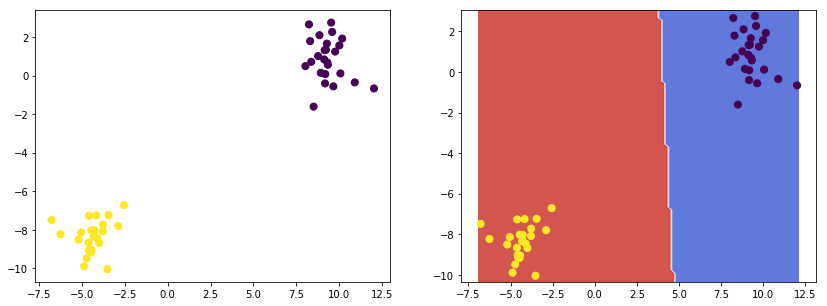

In [54]:
plot(X,y,np.matrix(w),1)

### Test problem 2

101


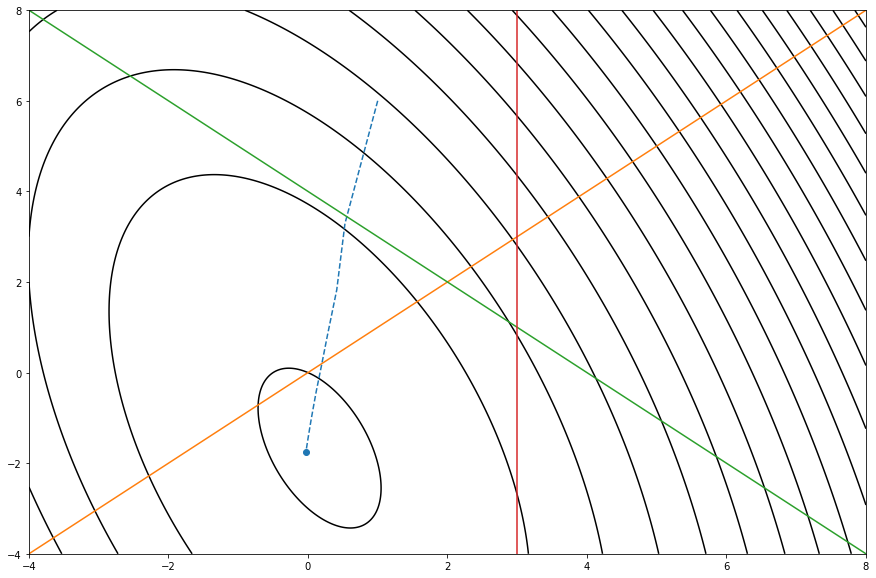

In [28]:
G = np.matrix([[8, 2],[2,2]])
g = np.matrix([[2],[3]])
A = np.matrix([[1,-1,-1],[-1,-1,0]])
x, z, s = np.matrix([[1],[6]]),np.matrix([[1],[1],[1]]),np.matrix([[1],[1],[1]])
b = np.matrix([[0],[-4],[-3]])

eta = 0.3
maxk = 100
w, path, k = _cvxopt(x, z, s, G, g, A, b, eta, maxk)

print(k)
pathList = []

for ele in path: 
    pathList.append([ele[0,0],ele[1,0]])
    
pathListStacked = np.vstack(pathList)

x = np.linspace(-4,8, 1000)
x2 = np.linspace(3,3, 1000)
y = np.linspace(-4,8, 1000)
y2 = np.linspace(-4,8, 1000)

def f(x1,x2):
    
    f = 2*x1 + 3*x2 + 4*x1**2 + 2*x1*x2 + x2**2
    
    return f

c1 = x
c2 = -x + 4
c3 = 3

X, Y = np.meshgrid(x, y)
Z = f(X, Y)

plt.figure(figsize=(15,10))
plt.plot(pathListStacked[:,0],pathListStacked[:,1],'--')
plt.plot(x,c1)
plt.plot(x,c2)
plt.plot(x2,y2)
plt.scatter(pathListStacked[len(pathListStacked)-1,0],pathListStacked[len(pathListStacked)-1,1])
plt.contour(X, Y, Z,20 ,colors='black')

In [3]:
def _cvxoptFull(x, z, y, s, G, g, C, d, A, b, eta, maxk):
    
    
    path = []
    path.append(x)
    
    eta = eta
    
    #compute the residuals
    mA, nA = A.shape[0], A.shape[1]
    
    mC, nC = C.shape[0], C.shape[1]
    
    e = np.matrix(np.ones((nC,1)))
    
    rL = G*x + g - A*y - C*z
    rA = -A.T*x + b
    rC = -C.T*x + s + d
    rsz = np.multiply(s,z)
    mu = np.sum(np.multiply(z,s))/nC
    
    # number of iteration, epsilon, tolerance
    
    k = 0
    #maxk = 2000
    eps_L = 1e-10
    eps_A = 1e-10
    eps_C = 1e-10
    eps_mu = 1e-10
    
    while (k <= maxk):# and np.linalg.norm(rL)>=eps_L and np.linalg.norm(rA)>=eps_A and np.linalg.norm(rC)>=eps_C and abs(rsz).all()>=eps_mu):
    
        
        # solve the sytem of equation : predictor step
        
        lhs = np.block([[G,-A,-C],[-A.T,np.zeros((nA,nA)),np.zeros((nA,nC))],[-C.T,np.zeros((nC,nA)),-np.diag((s/z).A1)]])
        
        L, D, P = ldl(lhs)
        
        L, D, P = np.matrix(L), np.matrix(D), np.matrix(np.eye(len(L))[:,P])
        
        rhs = np.block([[-rL],[-rA],[-rC + rsz/z]])
        
        #dxyz_a = np.linalg.solve(lhs,rhs)
        dxyz_a = P*(np.linalg.inv(L.T)*(np.linalg.inv(D)*(np.linalg.inv(L)*(P.T*rhs))))
        
        dx_a = dxyz_a[0:len(x)]
        dy_a = dxyz_a[len(x):len(y)+len(x)]
        dz_a = dxyz_a[len(y)+len(x):len(x)+len(y)+len(z)]        
        ds_a = -((rsz + np.multiply(s,dz_a))/z)
        
        # compute alpha_aff
        
        alpha_a = 1
        
        idx_z = np.nonzero(dz_a < 0)
        
        if (len(idx_z[0])!=0):
            alpha_a =  min(alpha_a, np.min(-z[idx_z]/dz_a[idx_z]))
            
        idx_s = np.where(ds_a < 0)
        
        if (len(idx_s[0])!=0):
            alpha_a =  min(alpha_a, np.min(-s[idx_s]/ds_a[idx_s]))
        
        mu_a = ((z + alpha_a*dz_a).T*(s + alpha_a*ds_a))/nC
        
        sigma = np.linalg.matrix_power(mu_a/mu,3)
        
    
        # solve the sytem of equation : corrector step
        
        rsz = rsz + np.multiply(ds_a,dz_a) - sigma[0,0]*mu*e
        rhs = np.block([[-rL],[-rA],[-rC + rsz/z]])
        #dxyz = np.linalg.solve(lhs,rhs)
        dxyz = P*(np.linalg.inv(L.T)*(np.linalg.inv(D)*(np.linalg.inv(L)*(P.T*rhs))))
        
        dx = dxyz[0:len(x)]
        dy = dxyz[len(x):len(y) + len(x)]
        dz = dxyz[len(y) + len(x):len(x) + len(y) + len(z)]
        ds = -((rsz + np.multiply(s,dz))/z)        
        
        # compute alpha
        
        alpha = 1
        
        idx_z = np.where(dz < 0)
        
        if (len(idx_z[0])!=0):
            alpha =  min(alpha, np.min(-z[idx_z]/dz[idx_z]))
            
        idx_s = np.where(ds < 0)
        
        if (len(idx_s[0])!=0):
            alpha =  min(alpha, np.min(-s[idx_s]/ds[idx_s]))
            
        # Update x, z, s
        
        #print(alpha)
        x = x + eta*np.multiply(alpha,dx)
        z = z + eta*np.multiply(alpha,dz)
        y = y + eta*np.multiply(alpha,dy)
        s = z + eta*np.multiply(alpha,ds)
        
        k = k+1
    
        # Update rhs and mu
        
        rL = G*x + g - A*y - C*z
        rA = -A.T*x + b
        rC = -C.T*x + s + d
        rsz = np.multiply(s,z)
        mu = np.sum(np.multiply(z,s))/nC
        
        path.append(x)
        
    return x, path, k


def plot(x, y, w, b):
    xx = np.linspace(min(x[:,0])-0.1, max(x[:,0])+0.1, 100)
    yy = np.linspace(min(x[:,1])-0.3, max(x[:,1])+0.3, 100)
    YY, XX = np.meshgrid(yy, xx)
    xy = np.array(np.vstack([XX.ravel(), YY.ravel()]).T)
    pred=[0]*len(xy)
    pred=np.array(pred)
    
    Threshold=[0]*len(xy)
        
    for i in range(0,len(xy)):
        
        Threshold[i] = classify(xy[i,:].reshape(1,-1)[0],w,b)

        if Threshold[i]>=0:
            pred[i]=1
        else:
            pred[i]=0
    
    Z=pred.reshape(XX.shape)
    f = plt.figure(figsize=(14,5))
    ax = f.add_subplot(121)
    ax2 = f.add_subplot(122)
    ax.scatter(X[:, 0], X[:, 1], s=50,c=y)
    plt.subplot(122)
    ax2.contourf(XX, YY, Z,cmap=plt.cm.coolwarm,alpha=0.9)
    ax2.scatter(X[:, 0], X[:, 1], s=50,c=y)
    plt.show()
    
def classify(x, w, b):

    return np.dot(w.T,x) + b

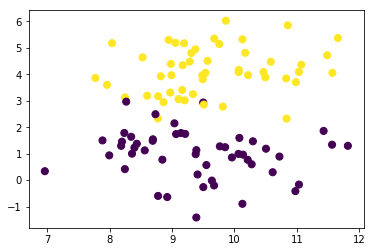

In [24]:
X, target = make_blobs(n_samples=100, centers=2, random_state = 4)
target[np.where(target==0.0)]=-1

plt.scatter(X[:, 0], X[:, 1], s=50,c=target)
c = 0.025
sigma = 100
N = X.shape[0]
K = np.dot(X,X.T)
#xsquared = (np.diag(K)*np.ones((1,N))).T
#b1 = np.ones((N,1))
#K -= 0.5*(np.dot(xsquared,b1.T) + np.dot(b1,xsquared.T))
#K = np.exp(K/(2.*sigma**2))
'''
def classify2(Y, xsquared, sigma):

    K = np.dot(Y,X.T)
    c = (1./sigma * np.sum(Y**2,axis=1)*np.ones((1,np.shape(Y)[0]))).T
    c = np.dot(c,np.ones((1,np.shape(K)[1])))
    aa = np.dot(xsquared,np.ones((1,np.shape(K)[0]))).T
    K = K - 0.5*c - 0.5*aa
    K = np.exp(K/(2.*self.sigma**2))

    y = np.zeros((np.shape(Y)[0],1))
    for j in range(np.shape(Y)[0]):
        for i in range(len(X)):
            self.y[j] += lambdas[i]*targets[i]*K[j,i]
        self.y[j] += self.b

    return np.sign(y)
'''
### Prepare data
### A is equality and C is inequality

G = np.multiply(np.matrix(target).T*np.matrix(target),K)
g = -np.matrix(np.ones((N,1)))
C = np.matrix(np.block([[-np.eye(N)],[np.eye(N)]])).T
d = np.matrix(np.block([[-c*np.ones((N,1))],[0*np.ones((N,1))]]))
A = np.matrix(target.reshape(N,1))
b = np.matrix([[0]])
x = np.matrix([[0]*N]).T
y = np.matrix([[0.1]]).T
z = np.matrix([[0.1]*len(C.T)]).T
s = np.matrix([[0.1]*len(C.T)]).T

In [8]:
np.matrix(target).T*np.matrix(target)

matrix([[ 1,  1,  1, -1, -1,  1,  1, -1, -1, -1],
        [ 1,  1,  1, -1, -1,  1,  1, -1, -1, -1],
        [ 1,  1,  1, -1, -1,  1,  1, -1, -1, -1],
        [-1, -1, -1,  1,  1, -1, -1,  1,  1,  1],
        [-1, -1, -1,  1,  1, -1, -1,  1,  1,  1],
        [ 1,  1,  1, -1, -1,  1,  1, -1, -1, -1],
        [ 1,  1,  1, -1, -1,  1,  1, -1, -1, -1],
        [-1, -1, -1,  1,  1, -1, -1,  1,  1,  1],
        [-1, -1, -1,  1,  1, -1, -1,  1,  1,  1],
        [-1, -1, -1,  1,  1, -1, -1,  1,  1,  1]])

In [25]:
eta = 0.1
maxk = 100
w,path, k = _cvxoptFull(x, z, y, s, G, g, C, d, A, b, eta,maxk)

In [28]:
sv

(array([ 0,  1, 11], dtype=int64), array([0, 0, 0], dtype=int64))

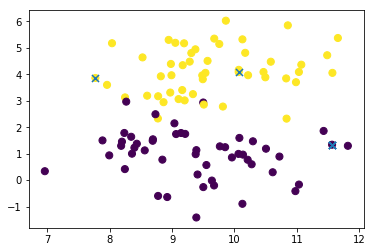

In [27]:
sv = np.where(w >= 1e-05)
plt.scatter(X[:, 0], X[:, 1], s=50,c=target)
plt.scatter(X[sv,0], X[sv,1],s=50,marker="x")

1001


C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\contour.py:1000: UserWarning: The following kwargs were not used by contour: 'color'
  s)


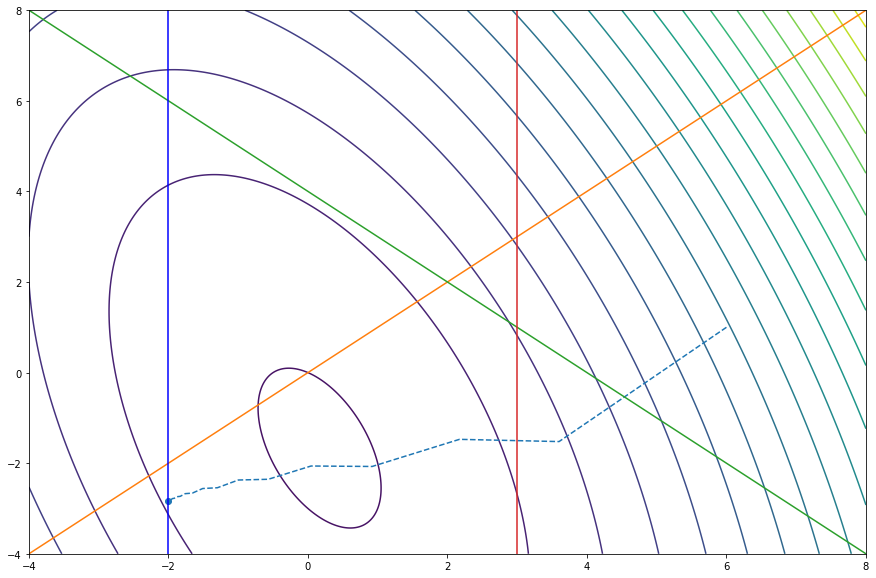

In [29]:
G = np.matrix([[8, 2],[2,2]])
g = np.matrix([[2],[3]])
C = np.matrix([[1,-1,-1],[-1,-1,0]])
x, y = np.matrix([[6],[1]]), np.matrix([[1]]) 
z, s = np.matrix([[1],[1],[1]]),np.matrix([[1],[1],[1]])
d = np.matrix([[0],[-4],[-3]])
A = np.matrix([[1],[0]])
b = np.matrix([[-2]])

eta = 0.3
maxk = 100
w, path, k = _cvxoptFull(x, z, y, s, G, g, C, d, A, b, eta, maxk)

#print(k)
pathList = []

for ele in path: 
    pathList.append([ele[0,0],ele[1,0]])
    
pathListStacked = np.vstack(pathList)

x = np.linspace(-4,8, 1000)
x2 = np.linspace(3,3, 1000)
y = np.linspace(-4,8, 1000)
y2 = np.linspace(-4,8, 1000)
x3 = np.linspace(-2,-2, 1000)
y3 = np.linspace(-4,8, 1000)

def f(x1,x2):
    
    f = 2*x1 + 3*x2 + 4*x1**2 + 2*x1*x2 + x2**2
    
    return f

c1 = x
c2 = -x + 4
c3 = (1 - x)
X, Y = np.meshgrid(x, y)
Z = f(X, Y)


plt.figure(figsize=(15,10))
plt.plot(pathListStacked[:,0],pathListStacked[:,1],'--')
plt.plot(x,c1)
plt.plot(x,c2)
plt.plot(x2,y2)
plt.plot(x3,y3, color = 'b')
plt.scatter(pathListStacked[len(pathListStacked)-1,0],pathListStacked[len(pathListStacked)-1,1])
plt.contour(X, Y, Z,20, color='black')
#plt.clabel(cnts, inline=True, fontsize=8)